**тематическое моделирование**

Евгений Борисов borisov.e@solarl.ru

In [1]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

## библиотеки

In [2]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'0.23.2'

## тексты

In [4]:
data = pd.read_pickle('../data/news.pkl.gz')
print('текстов:',len(data))
data.sample(4)

текстов: 3196


,text,tag
1746,"Американская компания Boeing приняла решение сократить производство широкофюзеляжных лайнеров 777 на 40% с августа 2017 года, сообщает RNS. Сейчас Boeing производит в среднем 8,3 лайнера в месяц. ...",economics
1686,"НЬЮ-ЙОРК, 13 декабря. /Корр. ТАСС Кирилл Волков/. Самолет германской авиакомпании Lufthansa совершил экстренную посадку в международном аэропорту имени Джона Кеннеди в Нью-Йорке после сообщения о ...",incident
2334,В Ростовской области сотрудники полиции устанавливают обстоятельства лобового столкновения двух грузовиков Volvo. В результате аварии травмы различной степени тяжести получили водители грузовых ма...,incident
1894,Самолет авиакомпании Lufthansa экстренно сел в аэропорту Кеннеди в Нью-Йорке из-за угрозы взрыва. Об этом сообщает РИА Новости.\n\nчитайте также Поезд Москва - Киев проверят после звонка о бомбе\n...,incident


## токенизация и очистка

In [5]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# NOUN	существительное
# VERB	глагол
# ADJF	прилагательное
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''

def string_normalizer(s):
    return re.sub(r'[\W]+',' ',s.lower().replace('ё','е'))

def text_normalizer(s):
    return [ word_normalizer(w) for w in string_normalizer(s).split() ]

In [6]:
data['ctext'] = data['text'].progress_apply(text_normalizer).apply(' '.join)

100%|██████████| 3196/3196 [01:41<00:00, 31.58it/s]


## модели

In [7]:
def print_top_words(model, feature_names, n_top_words=7):
    for topic_idx, topic in enumerate(model.components_):
        message = "Тема %d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [8]:
n_features = 1000
n_components = 10

### CountVectorizer + LatentDirichletAllocation

In [9]:
# tf features 
tf_vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features=n_features )
tf = tf_vectorizer.fit_transform(data['ctext'])
tf_feature_names = tf_vectorizer.get_feature_names()

# LDA - латентное размещение Дирихле
lda = LatentDirichletAllocation( n_components=n_components, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0 ).fit(tf)
print('\nLDA:\n')
print_top_words(lda, tf_feature_names)


LDA:

Тема 0: президент быть трамп сша свой россия который
Тема 1: быть год который человек работа декабрь тот
Тема 2: весь быть тот мочь который такой человек
Тема 3: год быть который один самый хороший фильм
Тема 4: матч команда быть который хороший чемпионат мяч
Тема 5: автомобиль быть водитель машина декабрь место произойти
Тема 6: компания пользователь сеть сайт интернет реклама сервис
Тема 7: народ дело район коренной рф житель малочисленный
Тема 8: год рубль миллион компания тысяча доллар рынок
Тема 9: группа минск декабрь старый внимание ваш поддерживать


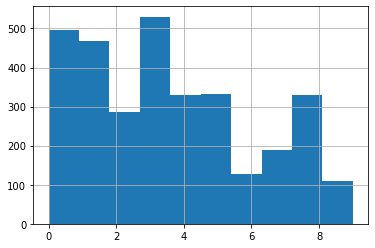

In [12]:
t = np.argmax(lda.transform(tf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (Frobenius norm)

In [13]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# NMF (Frobenius norm) - неотрицательное матричное разложение
nmf = NMF( n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )


NMF:

Тема 0: быть год который весь тот россия один
Тема 1: трамп сша президент дональд избранный бизнес пост
Тема 2: матч чемпионат динамо команда шахтёр лига клуб
Тема 3: водитель дтп авария произойти летний автобус автомобиль
Тема 4: автомобиль модель компания год рынок новый версия
Тема 5: учёный человек исследование университет мозг который организм
Тема 6: рубль миллион миллиард доллар тысяча год цена
Тема 7: фильм хороший премия награда номинация актёр картина
Тема 8: савченко депутат надежда украина партия лидер народный
Тема 9: народ коренной малочисленный север край фестиваль традиционный


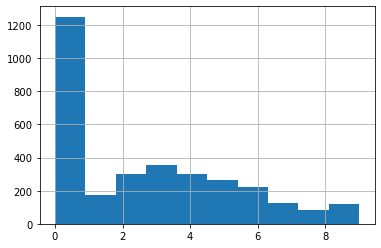

In [14]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (generalized Kullback-Leibler divergence)

In [15]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# NMF (generalized Kullback-Leibler divergence) 
nmf = NMF( n_components=n_components, random_state=1, beta_loss='kullback-leibler', 
          solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )


NMF:

Тема 0: быть который год тот россия этот мочь
Тема 1: президент трамп сша министр глава заявить путин
Тема 2: матч чемпионат команда клуб чемпион мир динамо
Тема 3: водитель летний дтп произойти улица место человек
Тема 4: автомобиль компания модель машина версия год новый
Тема 5: учёный человек который самый весь женщина мочь
Тема 6: рубль миллион доллар миллиард год тысяча цена
Тема 7: фильм хороший премия актёр год концерт картина
Тема 8: савченко украина депутат надежда государственный партия вопрос
Тема 9: пользователь народ коренной север малочисленный центр самолёт


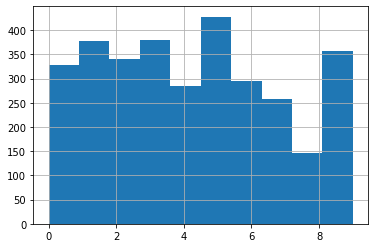

In [16]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()